In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
DATA_PATH = "/content/drive/MyDrive/CSE583_HSI/Indian_Pines_HSI/"

In [ ]:
!pip install numpy matplotlib scikit-learn spectral torch torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.0/249.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
!pip install --upgrade scikit-image

# **Applying pca**

In [ ]:
"""
Hyperspectral Image Super-Resolution with Deep Residual Learning using PCA-based Dimensionality Reduction
=========================================================================================================
Author: Kazi Hafiz Md Asad
Institution: North South University

This script loads an Indian Pine hyperspectral dataset from the provided .npy files
(indianpinearray.npy and IPgt.npy), applies PCA to reduce the spectral dimension, creates
a dataset of overlapping patches for training in the reduced PCA space, trains a Residual U-Net
for HSI reconstruction (in PCA space), and then evaluates the model (by inverting PCA) using
PSNR, SSIM, and SAM metrics. It also provides detailed visualizations (including PCA visualizations,
spectral profiles, error maps, aggregated spectral response, training loss curves, and
epoch versus evaluation metric graphs) suitable for inclusion in a research paper.
"""

# -------------------------------
# 1. Import Libraries
# -------------------------------
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import PCA
from tqdm import tqdm

# Import metrics from skimage
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# -------------------------------
# 2. Configuration
# -------------------------------
class Config:
    # Data parameters
    data_path = "indianpinearray.npy"   # full hyperspectral data with 200 bands
    gt_path = "IPgt.npy"                # ground truth for visualization (full bands)
    patch_size = 32
    batch_size = 8

    # PCA parameters
    pca_components = 3  # number of spectral components after dimensionality reduction

    # Model/training parameters
    num_epochs = 10
    learning_rate = 1e-4
    weight_decay = 1e-4
    checkpoint_path = "hsi_sr_model.pth"
    eval_sample_count = 100   # Number of evaluation patches per epoch

    # Visualization parameters (for visualization, we show full spectrum)
    # (If desired, you can adjust these indices after inversion)
    bands_to_plot = [0, 50, 100, 150, 199]  # example band indices
    pca_viz_components = 3  # for PCA-based visualization in plot_comparison

In [ ]:
# -------------------------------
# 3. Dataset Class (working in PCA space)
# -------------------------------
class HSIDataset(Dataset):
    def __init__(self, data):
        """
        data: PCA-transformed data of shape (H, W, pca_components)
        """
        self.data = data
        self.ps = Config.patch_size
        self.pad = self.ps // 2
        # Reflection padding to handle boundary conditions
        self.padded = np.pad(data,
                             ((self.pad, self.pad),
                              (self.pad, self.pad),
                              (0, 0)),
                             mode='reflect')

    def __len__(self):
        # Total number of pixels in the original spatial dimensions
        return self.data.shape[0] * self.data.shape[1]

    def __getitem__(self, idx):
        # Convert linear index to 2D pixel location
        i = idx // self.data.shape[1]
        j = idx % self.data.shape[1]
        patch = self.padded[i:i+self.ps, j:j+self.ps, :].copy()
        # Convert from (H, W, C) to (C, H, W)
        return torch.tensor(patch, dtype=torch.float32).permute(2, 0, 1)

In [ ]:
# -------------------------------
# 4. Model Architecture (modified input/output channels)
# -------------------------------
class ResidualBlock(nn.Module):
    """Residual block with spectral normalization."""
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(channels, channels, 3, padding=1)),
            nn.LeakyReLU(0.2),
            nn.utils.spectral_norm(nn.Conv2d(channels, channels, 3, padding=1))
        )

    def forward(self, x):
        return x + self.conv(x)

class HSIResUNet(nn.Module):
    """Residual U-Net for HSI reconstruction in PCA space."""
    def __init__(self):
        super().__init__()
        in_channels = Config.pca_components  # now reduced instead of 200
        # Encoder
        self.enc1 = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(in_channels, 64, 3, padding=1)),
            ResidualBlock(64),
            nn.LeakyReLU(0.2)
        )
        self.enc2 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.utils.spectral_norm(nn.Conv2d(64, 128, 3, padding=1)),
            ResidualBlock(128),
            nn.LeakyReLU(0.2)
        )

        # Decoder
        self.dec1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.utils.spectral_norm(nn.Conv2d(128, 64, 3, padding=1)),
            ResidualBlock(64),
            nn.LeakyReLU(0.2)
        )
        self.final = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(64, 32, 3, padding=1)),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, in_channels, 1)
        )

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(x1)
        x = self.dec1(x2)
        return self.final(x)

In [ ]:
# -------------------------------
# 5. Metrics and Visualization Functions (with PCA inversion)
# -------------------------------
def spectral_angle_mapper(original, reconstructed):
    """Calculate the spectral angle (SAM) in radians."""
    orig_flat = original.reshape(-1, original.shape[-1])
    recon_flat = reconstructed.reshape(-1, reconstructed.shape[-1])
    dot_product = np.sum(orig_flat * recon_flat, axis=1)
    norm_orig = np.linalg.norm(orig_flat, axis=1)
    norm_recon = np.linalg.norm(recon_flat, axis=1)
    valid = (norm_orig > 1e-6) & (norm_recon > 1e-6)
    cos_sim = np.clip(dot_product[valid] / (norm_orig[valid] * norm_recon[valid]), -1.0, 1.0)
    return np.mean(np.arccos(cos_sim))

def calculate_metrics(original, reconstructed):
    """
    Calculate reconstruction metrics:
    Returns average PSNR, SSIM, and SAM over all spectral bands.
    original and reconstructed are assumed to be in the original full spectral space.
    """
    metrics = {'PSNR': 0.0, 'SSIM': 0.0, 'SAM': spectral_angle_mapper(original, reconstructed)}
    for b in range(original.shape[-1]):
        metrics['PSNR'] += peak_signal_noise_ratio(original[..., b], reconstructed[..., b], data_range=1.0)
        metrics['SSIM'] += structural_similarity(original[..., b], reconstructed[..., b], data_range=1.0)
    metrics['PSNR'] /= original.shape[-1]
    metrics['SSIM'] /= original.shape[-1]
    return metrics

def plot_comparison(original, reconstructed, gt):
    """
    Visual comparison: PCA visualization (on the full spectrum), spectral profiles, and band comparisons.
    original and reconstructed are assumed to be full spectrum arrays (after PCA inversion).
    gt is the ground truth composite image.
    """
    plt.figure(figsize=(20, 12))

    # Ground truth (assumed to be provided as a composite or single-band image)
    plt.subplot(3, 4, 1)
    plt.imshow(gt, cmap='jet')
    plt.title('Ground Truth')

    # PCA Visualization on original and reconstructed full spectrum
    pca = PCA(n_components=Config.pca_viz_components)
    H, W, C = original.shape
    orig_pca = pca.fit_transform(original.reshape(-1, C)).reshape(H, W, Config.pca_viz_components)
    recon_pca = pca.transform(reconstructed.reshape(-1, C)).reshape(H, W, Config.pca_viz_components)
    plt.subplot(3, 4, 2)
    plt.imshow((orig_pca - orig_pca.min())/(orig_pca.max()-orig_pca.min()))
    plt.title('Original PCA')
    plt.subplot(3, 4, 3)
    plt.imshow((recon_pca - recon_pca.min())/(recon_pca.max()-recon_pca.min()))
    plt.title('Reconstructed PCA')

    # Spectral profiles at random locations
    plt.subplot(3, 4, 4)
    for _ in range(3):
        x, y = np.random.randint(0, H, 2)
        plt.plot(original[x, y], 'b', alpha=0.5)
        plt.plot(reconstructed[x, y], 'r', alpha=0.5)
    plt.title("Random Spectral Profiles")

    # Band comparisons (3 pairs)
    for i, band in enumerate(Config.bands_to_plot[:3]):
        plt.subplot(3, 4, 5 + i*2)
        plt.imshow(original[..., band], cmap='gray')
        plt.title(f'Original Band {band}')
        plt.subplot(3, 4, 6 + i*2)
        plt.imshow(reconstructed[..., band], cmap='gray')
        plt.title(f'Reconstructed Band {band}')

    plt.tight_layout()
    plt.show()


In [ ]:
def plot_loss_curve(losses):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(losses)+1), losses, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Average L1 Loss")
    plt.title("Training Loss Curve")
    plt.grid(True)
    plt.show()

def plot_eval_metrics(epoch_list, epoch_psnr, epoch_ssim, epoch_sam):
    # Plot Epoch vs PSNR, SSIM, and SAM in separate subplots
    plt.figure(figsize=(14, 4))

    plt.subplot(1, 3, 1)
    plt.plot(epoch_list, epoch_psnr, marker='s', color='green')
    plt.xlabel("Epoch")
    plt.ylabel("Average PSNR (dB)")
    plt.title("Epoch vs PSNR")
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(epoch_list, epoch_ssim, marker='^', color='purple')
    plt.xlabel("Epoch")
    plt.ylabel("Average SSIM")
    plt.title("Epoch vs SSIM")
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(epoch_list, epoch_sam, marker='d', color='orange')
    plt.xlabel("Epoch")
    plt.ylabel("Average SAM (radians)")
    plt.title("Epoch vs SAM")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_aggregated_spectral_response(dataset, model, pca, num_eval=100):
    """
    Compute and plot average spectral response over random evaluation patches.
    Reconstruct full spectra using the PCA inverse transform.
    """
    orig_spectra = []
    recon_spectra = []
    model.eval()
    device = next(model.parameters()).device
    for _ in range(num_eval):
        patch = dataset[np.random.randint(0, len(dataset))]
        patch_tensor = patch.unsqueeze(0).to(device)
        with torch.no_grad():
            recon = model(patch_tensor).cpu().squeeze().permute(1, 2, 0).numpy()
        # Invert PCA for the patch. patch shape: (patch_size, patch_size, pca_components)
        orig_patch = patch.cpu().permute(1, 2, 0).numpy()
        H, W, _ = orig_patch.shape
        orig_full = pca.inverse_transform(orig_patch.reshape(-1, Config.pca_components)).reshape(H, W, -1)
        recon_full = pca.inverse_transform(recon.reshape(-1, Config.pca_components)).reshape(H, W, -1)
        orig_spectra.append(orig_full.mean(axis=(0, 1)))
        recon_spectra.append(recon_full.mean(axis=(0, 1)))
    avg_orig = np.mean(orig_spectra, axis=0)
    avg_recon = np.mean(recon_spectra, axis=0)
    plt.figure(figsize=(8, 5))
    plt.plot(np.arange(avg_orig.shape[0]), avg_orig, 'b-', label='Avg Original')
    plt.plot(np.arange(avg_recon.shape[0]), avg_recon, 'r--', label='Avg Reconstructed')
    plt.xlabel("Spectral Band Index")
    plt.ylabel("Mean Normalized Reflectance")
    plt.title("Aggregated Spectral Response")
    plt.legend()
    plt.show()

In [ ]:
# -------------------------------
# 6. Main Training Workflow
# -------------------------------
def main():
    # Load and normalize full hyperspectral data (shape: H x W x 200)
    hsi_data = np.load(Config.data_path)  # full spectrum
    gt_data = np.load(Config.gt_path)      # used for visualization; assumed full spectrum
    hsi_data = (hsi_data - hsi_data.min()) / (hsi_data.max() - hsi_data.min())

    # ---------------------------
    # Apply PCA for dimension reduction
    # ---------------------------
    H, W, C = hsi_data.shape  # C should be 200
    pca = PCA(n_components=Config.pca_components)
    # Reshape data for PCA fit: each pixel is a sample
    hsi_data_reshaped = hsi_data.reshape(-1, C)
    pca_data_flat = pca.fit_transform(hsi_data_reshaped)
    # Reshape back to spatial dimensions but with reduced channels
    pca_data = pca_data_flat.reshape(H, W, Config.pca_components)

    # Create dataset and dataloader using PCA-transformed data
    dataset = HSIDataset(pca_data)
    dataloader = DataLoader(dataset, batch_size=Config.batch_size, shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = HSIResUNet().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=Config.learning_rate, weight_decay=Config.weight_decay)
    scaler = torch.cuda.amp.GradScaler()  # Automatic mixed precision

    # For tracking training and evaluation metrics per epoch
    train_losses = []
    epoch_psnr = []
    epoch_ssim = []
    epoch_sam  = []
    epoch_list = list(range(1, Config.num_epochs + 1))

    # Training loop
    for epoch in range(Config.num_epochs):
        model.train()
        epoch_loss = 0
        for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{Config.num_epochs}"):
            inputs = batch.to(device)  # shape: (batch, pca_components, patch_size, patch_size)
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = F.l1_loss(outputs, inputs)
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(dataloader)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch+1}: Training Loss = {avg_loss:.4f}")

        # Evaluate on random patches from the dataset after each epoch
        model.eval()
        psnr_list = []
        ssim_list = []
        sam_list = []
        for _ in range(Config.eval_sample_count):
            patch = dataset[np.random.randint(0, len(dataset))]
            patch_tensor = patch.unsqueeze(0).to(device)
            with torch.no_grad():
                recon_pca = model(patch_tensor).cpu().squeeze().permute(1, 2, 0).numpy()
            # Invert PCA to obtain full spectral representation for both original and reconstructed patches
            patch_np = patch.cpu().permute(1, 2, 0).numpy()
            patch_full = pca.inverse_transform(patch_np.reshape(-1, Config.pca_components)).reshape(Config.patch_size, Config.patch_size, C)
            recon_full = pca.inverse_transform(recon_pca.reshape(-1, Config.pca_components)).reshape(Config.patch_size, Config.patch_size, C)
            metrics = calculate_metrics(patch_full, recon_full)
            psnr_list.append(metrics['PSNR'])
            ssim_list.append(metrics['SSIM'])
            sam_list.append(metrics['SAM'])
        avg_epoch_psnr = np.mean(psnr_list)
        avg_epoch_ssim = np.mean(ssim_list)
        avg_epoch_sam  = np.mean(sam_list)
        epoch_psnr.append(avg_epoch_psnr)
        epoch_ssim.append(avg_epoch_ssim)
        epoch_sam.append(avg_epoch_sam)
        print(f"Epoch {epoch+1}: Eval PSNR = {avg_epoch_psnr:.2f} dB, SSIM = {avg_epoch_ssim:.4f}, SAM = {avg_epoch_sam:.4f} rad")

    # Final evaluation and visualization (only after final epoch)
    model.eval()
    with torch.no_grad():
        sample = next(iter(dataloader)).to(device)
        # Process one sample from PCA space through the model
        recon_pca_batch = model(sample).cpu().numpy().transpose(0, 2, 3, 1)
        orig_pca_batch = sample.cpu().numpy().transpose(0, 2, 3, 1)
        # For visualization, invert PCA for the first sample in the batch
        recon_full = pca.inverse_transform(recon_pca_batch[0].reshape(-1, Config.pca_components)).reshape(Config.patch_size, Config.patch_size, C)
        orig_full = pca.inverse_transform(orig_pca_batch[0].reshape(-1, Config.pca_components)).reshape(Config.patch_size, Config.patch_size, C)
        metrics = calculate_metrics(orig_full, recon_full)
        print(f"\nFinal Evaluation After Training:")
        print(f"PSNR: {metrics['PSNR']:.4f} dB")
        print(f"SSIM: {metrics['SSIM']:.4f}")
        print(f"SAM: {metrics['SAM']:.4f} rad ({np.degrees(metrics['SAM']):.2f}°)\n")
        plot_comparison(orig_full, recon_full, gt_data)

    # Plot training loss curve and evaluation metrics curves
    plot_loss_curve(train_losses)
    plot_eval_metrics(epoch_list, epoch_psnr, epoch_ssim, epoch_sam)
    plot_aggregated_spectral_response(dataset, model, pca, num_eval=Config.eval_sample_count)

    # Save final model
    torch.save(model.state_dict(), Config.checkpoint_path)
    print("Training complete! Model saved as", Config.checkpoint_path)

<ipython-input-7-f43f661d7c83>:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Automatic mixed precision
Epoch 1/10:   0%|          | 0/2629 [00:00<?, ?it/s]<ipython-input-7-f43f661d7c83>:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/10: 100%|██████████| 2629/2629 [00:38<00:00, 68.18it/s]


Epoch 1: Training Loss = 0.0599
Epoch 1: Eval PSNR = 49.65 dB, SSIM = 0.9828, SAM = 0.0158 rad


Epoch 2/10: 100%|██████████| 2629/2629 [00:39<00:00, 66.67it/s]


Epoch 2: Training Loss = 0.0390
Epoch 2: Eval PSNR = 50.90 dB, SSIM = 0.9892, SAM = 0.0135 rad


Epoch 3/10: 100%|██████████| 2629/2629 [00:36<00:00, 72.90it/s]


Epoch 3: Training Loss = 0.0324
Epoch 3: Eval PSNR = 52.23 dB, SSIM = 0.9913, SAM = 0.0122 rad


Epoch 4/10: 100%|██████████| 2629/2629 [00:35<00:00, 74.20it/s]


Epoch 4: Training Loss = 0.0288
Epoch 4: Eval PSNR = 52.88 dB, SSIM = 0.9931, SAM = 0.0109 rad


Epoch 5/10: 100%|██████████| 2629/2629 [00:35<00:00, 73.18it/s]


Epoch 5: Training Loss = 0.0264
Epoch 5: Eval PSNR = 53.40 dB, SSIM = 0.9943, SAM = 0.0123 rad


Epoch 6/10: 100%|██████████| 2629/2629 [00:35<00:00, 73.06it/s]


Epoch 6: Training Loss = 0.0247
Epoch 6: Eval PSNR = 53.97 dB, SSIM = 0.9949, SAM = 0.0098 rad


Epoch 7/10: 100%|██████████| 2629/2629 [00:35<00:00, 74.24it/s]


Epoch 7: Training Loss = 0.0234
Epoch 7: Eval PSNR = 54.88 dB, SSIM = 0.9956, SAM = 0.0089 rad


Epoch 8/10: 100%|██████████| 2629/2629 [00:34<00:00, 75.58it/s]


Epoch 8: Training Loss = 0.0224
Epoch 8: Eval PSNR = 55.16 dB, SSIM = 0.9958, SAM = 0.0087 rad


Epoch 9/10: 100%|██████████| 2629/2629 [00:35<00:00, 73.06it/s]


Epoch 9: Training Loss = 0.0215
Epoch 9: Eval PSNR = 55.34 dB, SSIM = 0.9959, SAM = 0.0085 rad


Epoch 10/10: 100%|██████████| 2629/2629 [00:35<00:00, 74.45it/s]


Epoch 10: Training Loss = 0.0207
Epoch 10: Eval PSNR = 55.77 dB, SSIM = 0.9962, SAM = 0.0081 rad

Final Evaluation After Training:
PSNR: 54.1264 dB
SSIM: 0.9964
SAM: 0.0101 rad (0.58°)



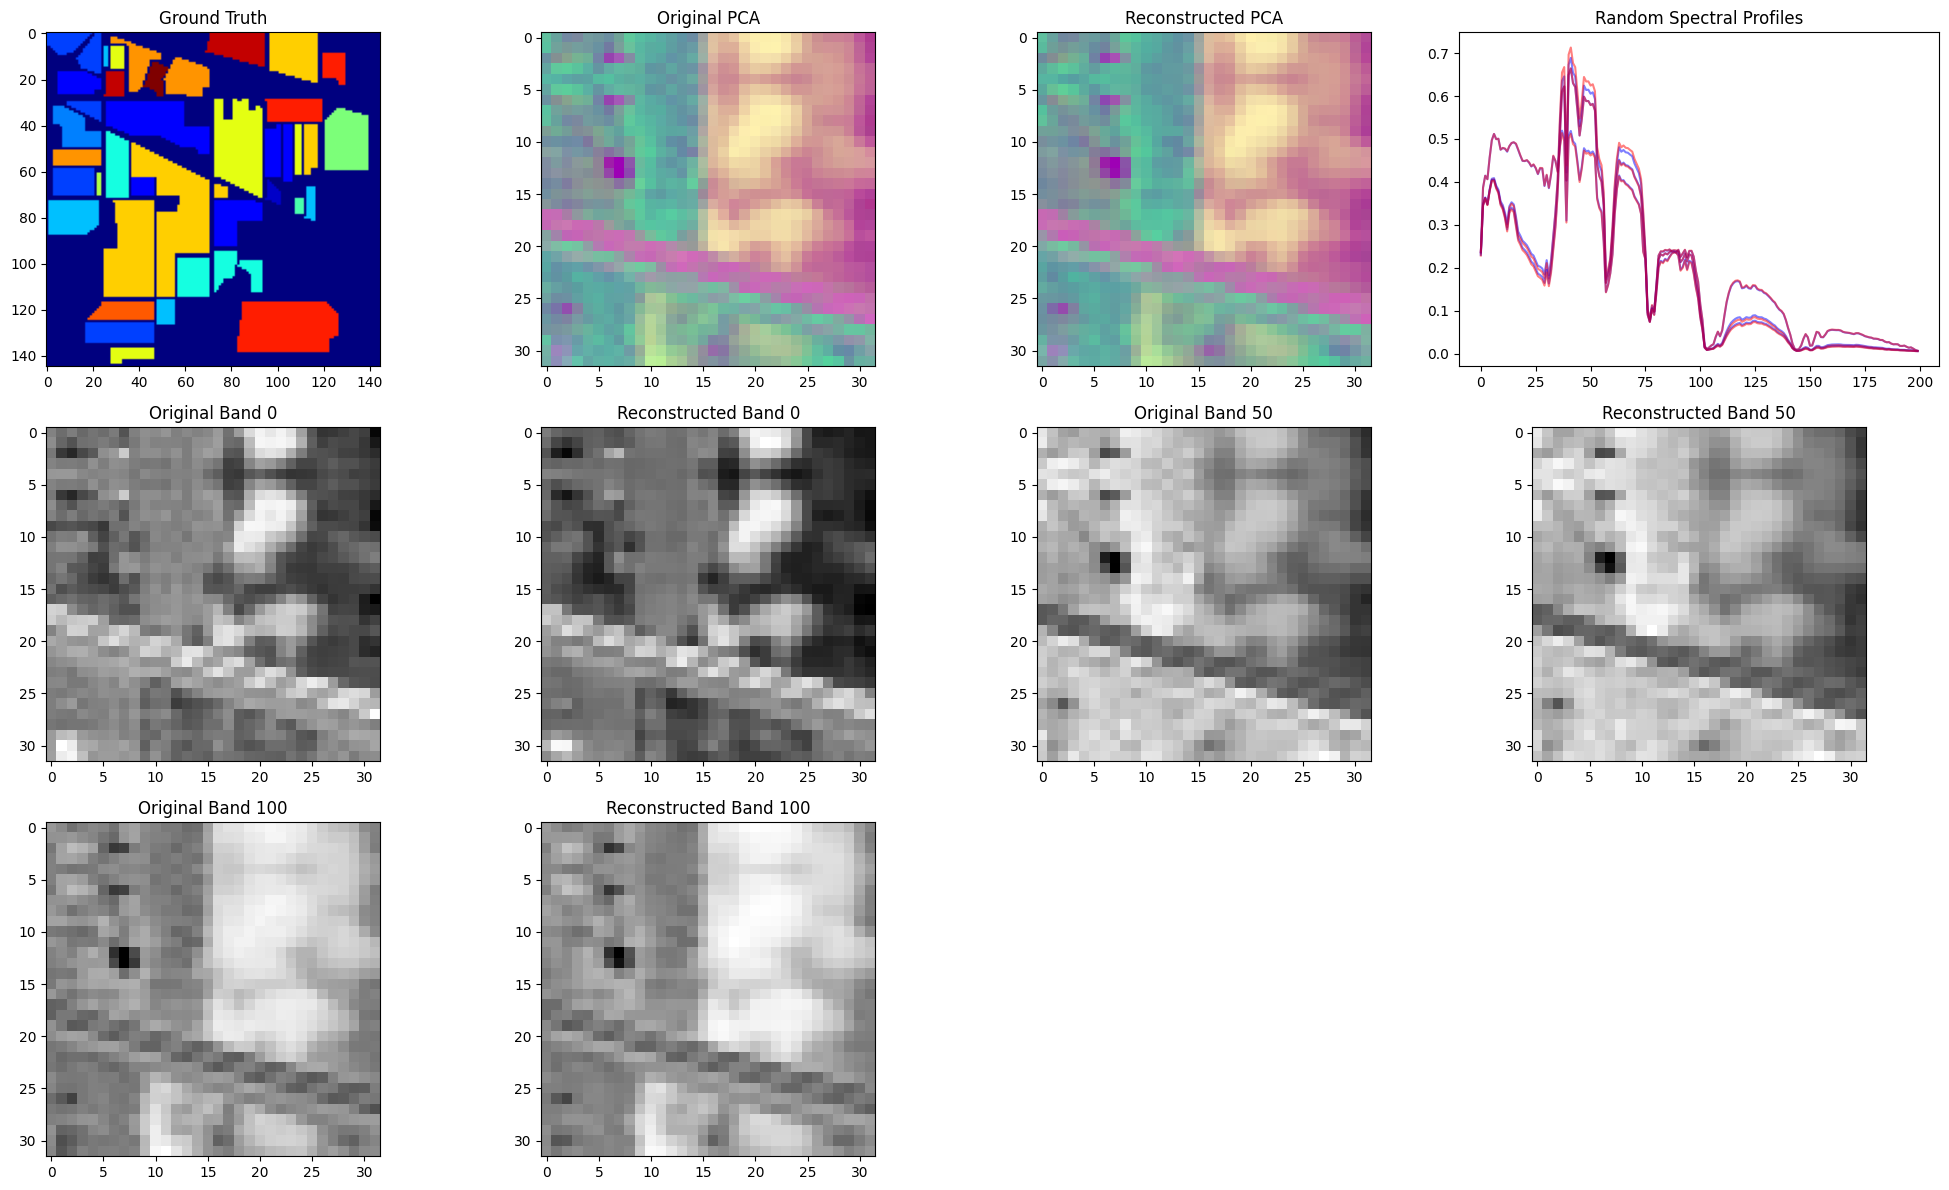

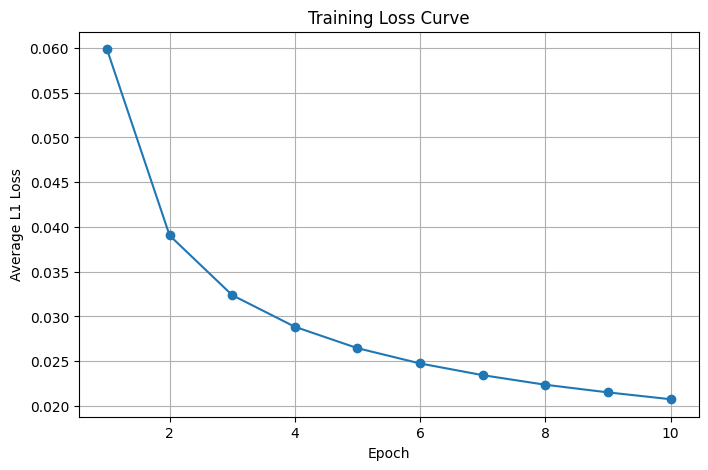

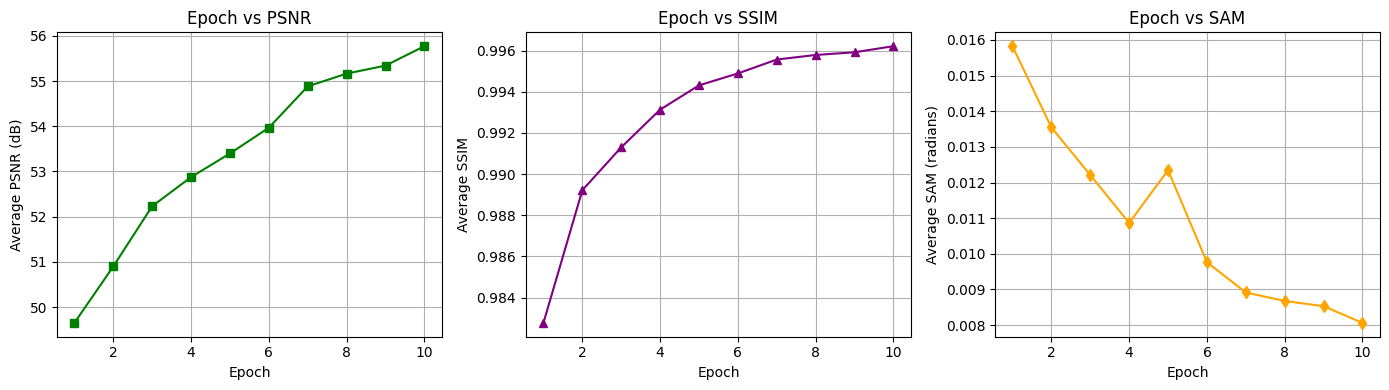

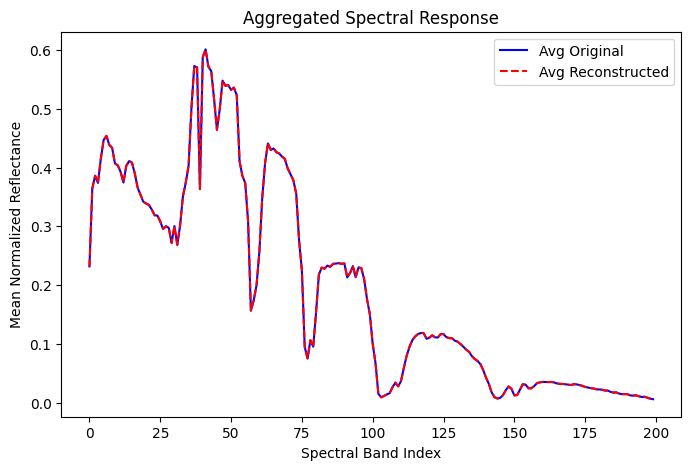

Training complete! Model saved as hsi_sr_model.pth


In [ ]:


if __name__ == "__main__":
    main()
